# Phase shift identification 

refs: 

https://stackoverflow.com/a/27546385/9357244

https://stackoverflow.com/a/6157997/9357244

FFT https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html 


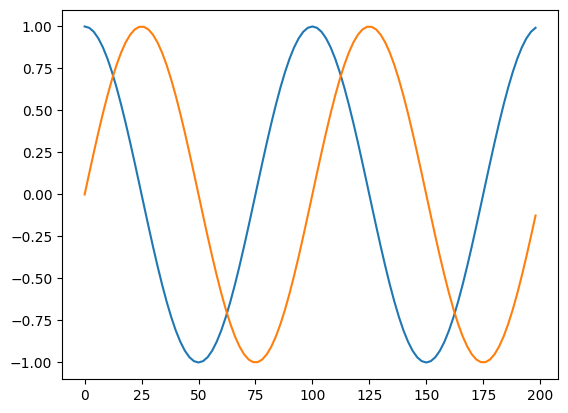

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

frq = 0.01  # [Hz]
nsamples = 100
maxtime = 200 
phase_lag = - np.pi  / 2

t = np.linspace(0, maxtime, nsamples, endpoint=False)

a = np.cos(2 * np.pi * frq * t)
b = np.cos(2 * np.pi * frq * t + phase_lag)

plt.plot(t, a)
plt.plot(t, b)

# Cross correlation

The cross correlation between two signals is a measure of how well the two signals align. 

For discrete signals (which we have), $a(t)$ and $(b(t)$ the correlation can be calculated for a specified time shift, $\tau$ with 

$\mathrm{xcorr}(\tau) = \sum \overline{a(t)} b(t + \tau)$

the bar over $a$,  $\overline{a(t)}$ indicates the complex conjugate, for when you're working with sinusoids in complex space. For our purposes here, we'll be working with only real valued data, and so we can simplify to 

$\mathrm{xcorr}(\tau) = \sum a(t) b(t + \tau)$

So what we want is to find $\tau$ that maximizes the correlation. Let's check what that means graphically. 

Let's create two functions: `shift_with_pad` will shift an array by padding either the left or right end of the array and then dropping the elements that get bumped out. `corr_single` calculates the correlation for a single time shift

In [2]:
def shift_with_pad(b, shift):
    if shift < 0:
        shift = np.abs(shift)        
        shifted = np.pad(b, [0, shift])[shift:]
    else:
        shifted = np.pad(b, [shift, 0])[0:b.size]
    return shifted

def corr_single(a, b, shift):
    shifted = shift_with_pad(b, shift)
    return np.sum(a * shifted)

now let's shift and check out our curves

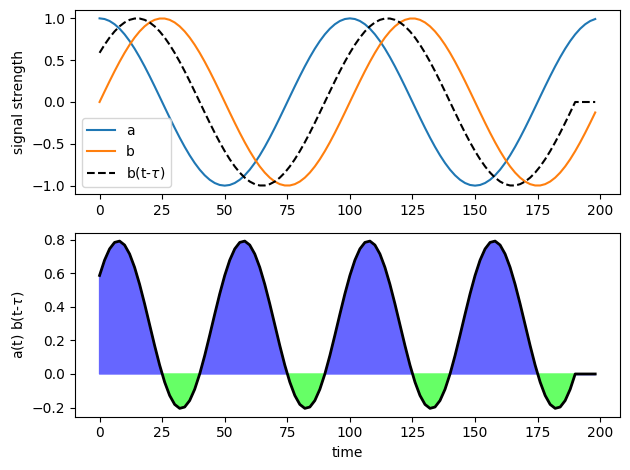

In [3]:
shifted = shift_with_pad(b, -5)
f, axs = plt.subplots(nrows=2, ncols = 1)
axs[0].plot(t, a, label='a')
axs[0].plot(t, b, label='b')
axs[0].set_ylabel(r"signal strength")

axs[0].plot(t, shifted, '--k', label = r"b(t-$\tau$)")
axs[0].legend()
product = shifted * a
axs[1].plot(t, product, linewidth=2, color='black')
axs[1].fill_between(t, product, where=product>=0, interpolate=True, color=(.4, .4, 1.0, 1.0))
axs[1].fill_between(t, product, where=product<0, interpolate=True, color=(.4, 1.0, 0.4, 1.0))
axs[1].set_ylabel(r"a(t) b(t-$\tau$)")
axs[1].set_xlabel(r"time")
f.set_tight_layout('tight')

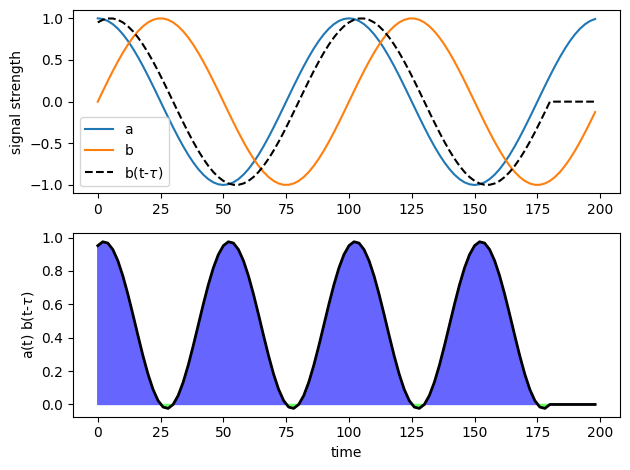

In [4]:
shifted = shift_with_pad(b, -10)
f, axs = plt.subplots(nrows=2, ncols = 1)
axs[0].plot(t, a, label='a')
axs[0].plot(t, b, label='b')
axs[0].set_ylabel(r"signal strength")

axs[0].plot(t, shifted, '--k', label = r"b(t-$\tau$)")
axs[0].legend()
product = a * shifted
axs[1].plot(t, product, linewidth=2, color='black')
axs[1].fill_between(t, product, where=product>=0, interpolate=True, color=(.4, .4, 1.0, 1.0))
axs[1].fill_between(t, product, where=product<0, interpolate=True, color=(.4, 1.0, 0.4, 1.0))
axs[1].set_ylabel(r"a(t) b(t-$\tau$)")
axs[1].set_xlabel(r"time")
f.set_tight_layout('tight')

repeating for all possible shifts 

In [5]:
shift_indexes = list(range(-a.size, a.size+1))
corrs = np.array([corr_single(a, b, shift) for shift in shift_indexes])

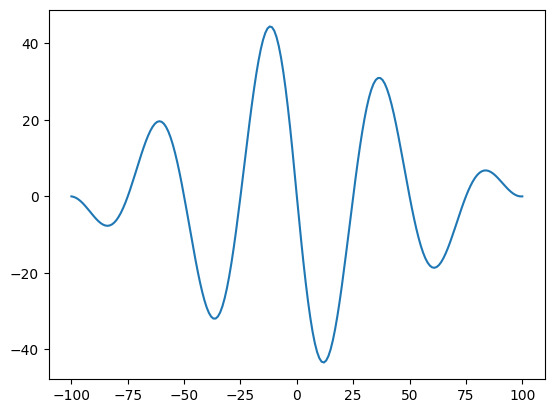

In [6]:
plt.plot(shift_indexes, corrs)

In [7]:
corrs.max()

44.41218941505808

In [8]:
max_corr_index = np.argmax(corrs)
max_corr_index

88

In [9]:
shift_indexes[max_corr_index]

-12

how much of a timeshift does that indicate?

In [10]:
dt = t[1] - t[0]
timeshift = shift_indexes[max_corr_index] * dt 
timeshift

-24.0

In [11]:
recovered_phase_lag = 2 * np.pi * frq * timeshift 
recovered_phase_lag

-1.5079644737231008

In [12]:
np.abs((phase_lag - recovered_phase_lag)/phase_lag)

0.03999999999999992

about 4% accuracy isn't great... 

before looking at why, let's encapsulate the above calculation in a function:

In [13]:
def calculate_crosscor(a, b, t, actual_phase_lag):

    # calculate the cross correlation for each index shift
    shift_indexes = list(range(-a.size, a.size+1))
    corrs = np.array([corr_single(a, b, shift) for shift in shift_indexes])
    
    max_corr_index = np.argmax(corrs)
    
    dt = t[1] - t[0]
    timeshift = shift_indexes[max_corr_index] * dt 
    recovered_phase_lag = 2 * np.pi * frq * timeshift

    err = np.abs((actual_phase_lag - recovered_phase_lag)/actual_phase_lag)
    return corrs, shift_indexes, recovered_phase_lag, err

In [14]:
_, _, recovered_phase_lag, err = calculate_crosscor(a, b, t, phase_lag)
recovered_phase_lag, err

(-1.5079644737231008, 0.03999999999999992)

let's think about why. How many cycles do we have?

In [15]:
frq * maxtime

2.0

increase that

In [16]:
ncycles = 20
maxtime = ncycles / frq
maxtime

2000.0

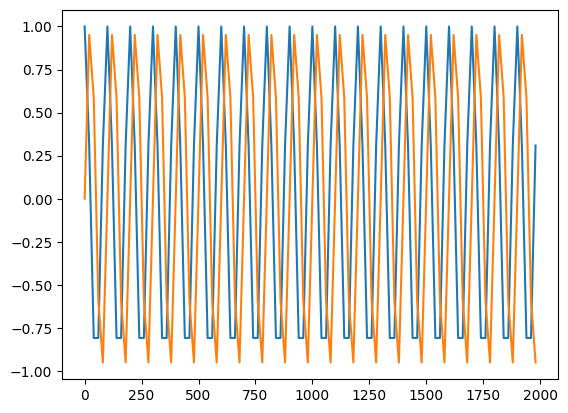

In [17]:
t = np.linspace(0, maxtime, nsamples, endpoint=False)
a = np.cos(2 * np.pi * frq * t)
b = np.cos(2 * np.pi * frq * t + phase_lag)

plt.plot(t, a)
plt.plot(t, b)

can already see we might have some problems because we havent increase the number of samples, let's run anyway:

In [18]:
_, _, recovered_phase_lag, err = calculate_crosscor(a, b, t, phase_lag)
recovered_phase_lag, err

(-1.2566370614359172, 0.2)

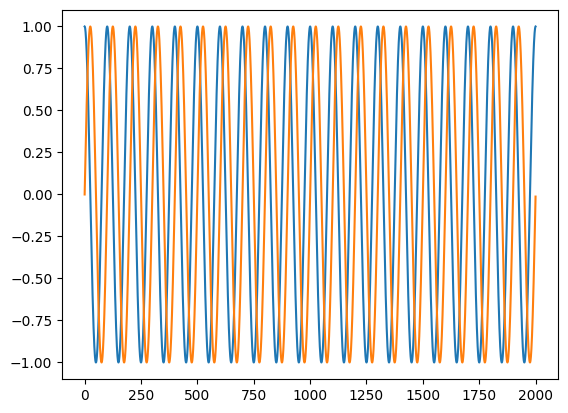

In [19]:
nsamples = 10000
t = np.linspace(0, maxtime, nsamples, endpoint=False)
a = np.cos(2 * np.pi * frq * t)
b = np.cos(2 * np.pi * frq * t + phase_lag)

plt.plot(t, a)
plt.plot(t, b)

(-1.5582299561805375, 0.007999999999999927)


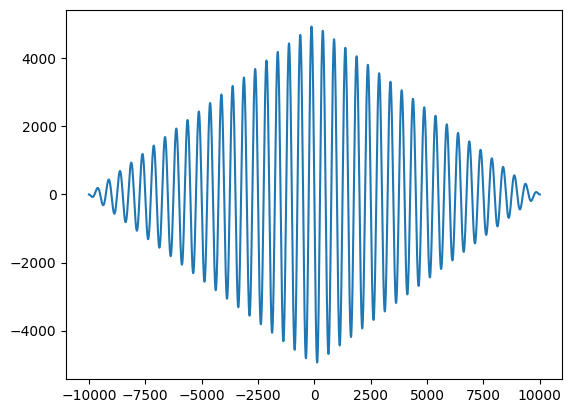

In [20]:
corr, index_shifts, recovered_phase_lag, err = calculate_crosscor(a, b, t, phase_lag)
print((recovered_phase_lag, err))
plt.plot(index_shifts, corr)

and we do a much better job of recovering our input lag. 

generally, though, scipy (or numpy) implementations will be faster, because we're manually looping in python, whereas scipy/numpy will handle that loop over lag index for you at a lower level in C

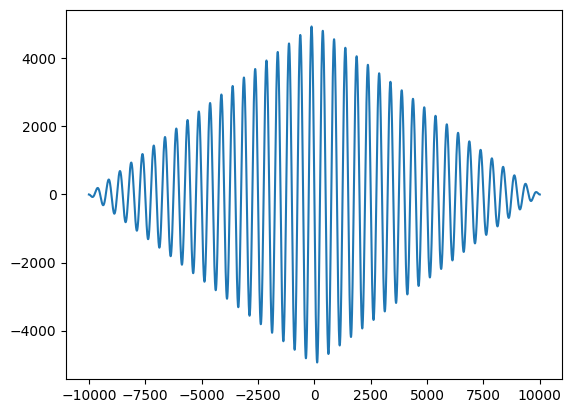

In [21]:
from scipy import signal

c = signal.correlate(a, b)
lags = signal.correlation_lags(a.size, b.size)  # lag indeces
plt.plot(lags, c)

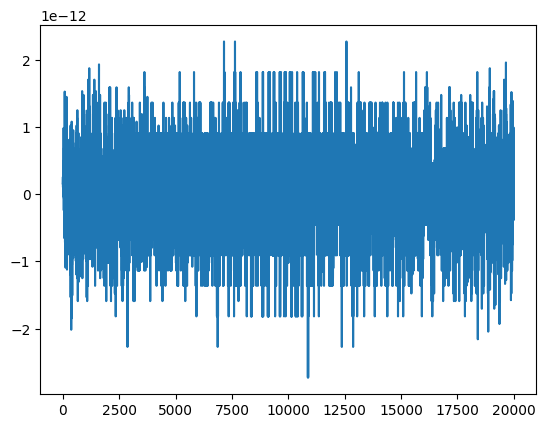

In [22]:
plt.plot(c - corr[1:-1])

(-124, -1.5582299561805377, -1.5707963267948966, 0.007999999999999785)


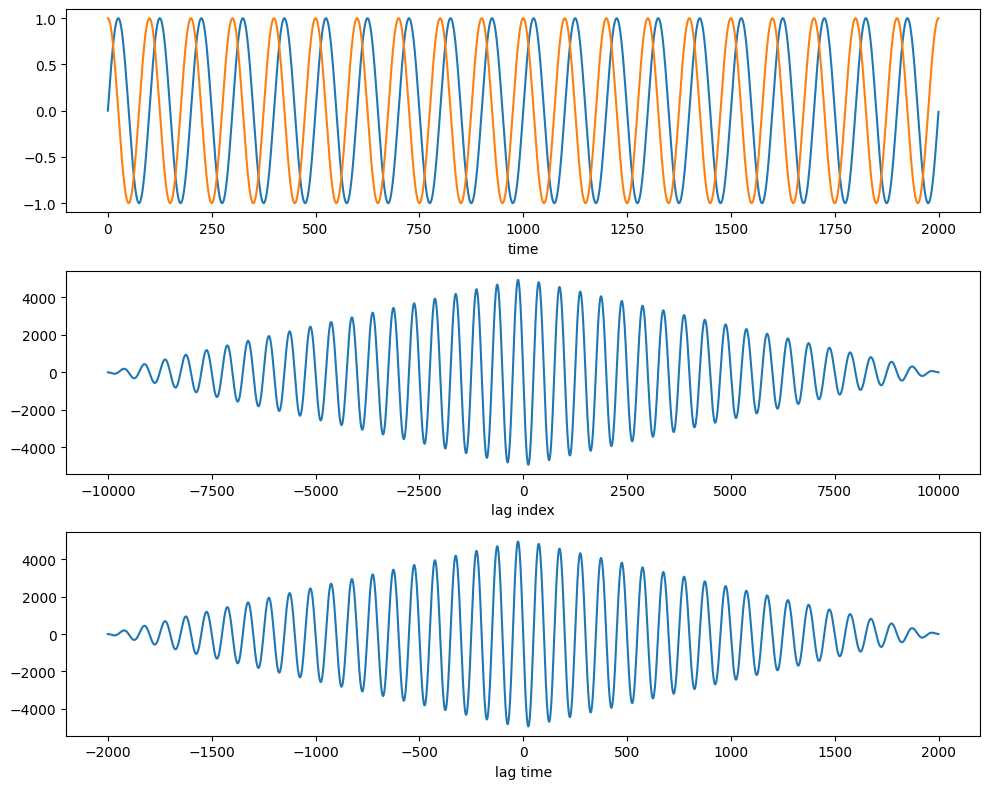

In [23]:
from scipy import signal

c = signal.correlate(a, b)
lags = signal.correlation_lags(a.size, b.size)  # lag indeces

dt = t[1] - t[0]
lags_time = lags * dt 
lag_index = lags[np.argmax(c)] # the lag_index that maximizes correlation
timeshift =  lag_index / lags.max() * t[-1]  # absolute timeshift
phase_shift = 2*np.pi* frq * timeshift 

err = np.abs((phase_lag - phase_shift)/phase_lag)
print((lag_index, phase_shift, phase_lag, err))

f, axs = plt.subplots(nrows =3 , ncols = 1, figsize=(10,8))

axs[0].plot(t, b)
axs[0].plot(t, a)
axs[0].set_xlabel('time')
axs[1].plot(lags, c) 
axs[1].set_xlabel("lag index") 

axs[2].plot(lags_time, c)
axs[2].set_xlabel("lag time") 

f.set_tight_layout('tight')

### problems

accuracy depends on the number of sample points and the number of cycles contained in the sample 

## Fourier Transforms 

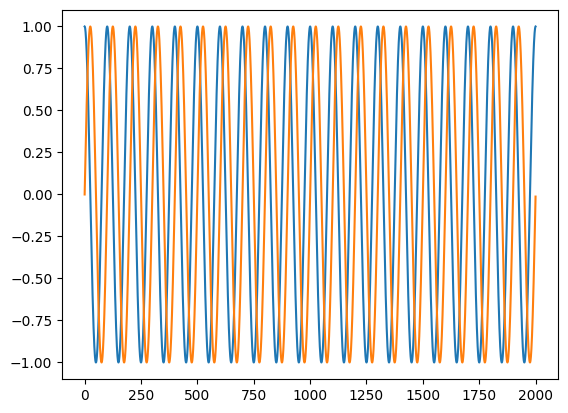

In [24]:
plt.plot(t, a)
plt.plot(t, b)

In [29]:
scipy.fft.fftfreq?

Signature: scipy.fft.fftfreq(n, d=1.0)
Docstring:
Return the Discrete Fourier Transform sample frequencies.

The returned float array `f` contains the frequency bin centers in cycles
per unit of the sample spacing (with zero at the start).  For instance, if
the sample spacing is in seconds, then the frequency unit is cycles/second.

Given a window length `n` and a sample spacing `d`::

  f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
  f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd

Parameters
----------
n : int
    Window length.
d : scalar, optional
    Sample spacing (inverse of the sampling rate). Defaults to 1.

Returns
-------
f : ndarray
    Array of length `n` containing the sample frequencies.

Examples
--------
>>> signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
>>> fourier = np.fft.fft(signal)
>>> n = signal.size
>>> timestep = 0.1
>>> freq = np.fft.fftfreq(n, d=timestep)
>>> freq
array([ 0.  ,  1.25,  2.5 , ..., -3.75, -2.5 ,

In [30]:
import scipy 

fft_a = scipy.fft.fft(a)
fft_b = scipy.fft.fft(b)

sample_spacing = t[1] - t[0]
freqs = scipy.fft.fftfreq(a.size, d = sample_spacing)

In [36]:
fft_a.shape

(10000,)

<StemContainer object of 3 artists>

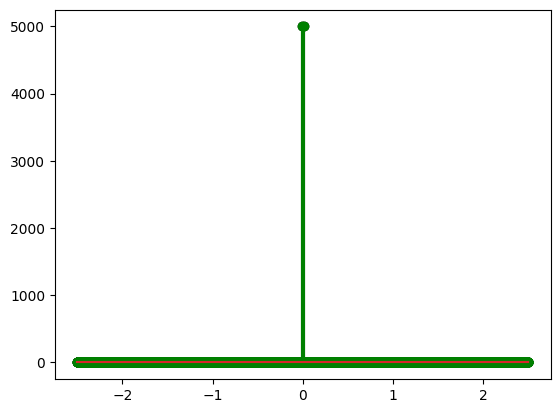

In [38]:
plt.stem(freqs, np.abs(fft_a),'k')
plt.stem(freqs, np.abs(fft_b),'g')

In [32]:
freqs[np.argmax(np.abs(fft_a))]

0.01

In [33]:
frq

0.01

In [41]:
our_freq_bin = np.argmax(np.abs(fft_a))

https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Shift_theorem 



In [46]:
fft_b[our_freq_bin]

(4.33692983353338e-11-5000j)

In [47]:
fft_a[our_freq_bin]

(5000+3.2427558992137846e-11j)

In [49]:
fft_b[our_freq_bin]/fft_a[our_freq_bin]

(2.188347868639191e-15-1j)

In [45]:
recovered_phase_lag = np.angle(fft_b[our_freq_bin]/fft_a[our_freq_bin]) # 
err = np.abs((phase_lag - recovered_phase_lag)/phase_lag)

phase_lag, recovered_phase_lag, err

(-1.5707963267948966, -1.5707963267948943, 1.4135798584282298e-15)

## Wavelet Analysis 